In [1]:
!pip install seaborn scikit-learn prettytable tensorboard --quiet

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

**Load Data**

In [4]:
# Primary Admissions information
# Add'.gz' if you uploaded .gz file
df = pd.read_csv('ADMISSIONS.csv')
# df = pd.read_csv('ADMISSIONS.csv.gz')

# Patient specific info such as gender
df_pat = pd.read_csv('PATIENTS.csv')

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv('DIAGNOSES_ICD.csv')

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv('ICUSTAYS.csv')

**Feature Engineering: ADMISSIONS Table**

In [5]:
list(df)

['ROW_ID',
 'SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA']

In [6]:
df["HOSPITAL_EXPIRE_FLAG"].value_counts()

HOSPITAL_EXPIRE_FLAG
0    53122
1     5854
Name: count, dtype: int64

In [7]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [8]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [9]:
# Pre-emptively drop some columns that I don't need anymore
df.drop(columns=['DISCHTIME', 'ROW_ID',
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

In [10]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [11]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(),
                                                     df['SUBJECT_ID'].nunique()))

5854 of 46520 patients died in the hospital


In [12]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,0


In [13]:
df['DECEASED'][df['DECEASED']== 1].describe()

count    5854.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: DECEASED, dtype: float64

In [14]:
df[df['DECEASED']==1].head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED
9,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,STATUS EPILEPTICUS,1
57,56,181711,2104-01-02 02:01:00,2104-01-08 10:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,NOT SPECIFIED,NaN,WHITE,HEAD BLEED,1
63,61,189535,2119-01-04 18:12:00,2119-02-03 01:35:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,CATHOLIC,MARRIED,WHITE,NON-HODGKINS LYMPHOMA;FEBRILE;NEUTROPENIA,1
70,67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,SINGLE,WHITE,SUBARACHNOID HEMORRHAGE,1
88,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,OTHER,MARRIED,WHITE,"GLIOBLASTOMA,NAUSEA",1


In [15]:
df['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


In [16]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

C:\Users\Water\AppData\Local\Temp\ipykernel_37092\1325925633.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
C:\Users\Water\AppData\Local\Temp\ipykernel_37092\1325925633.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

ETHNICITY
WHITE                     41325
OTHER/UNKNOWN              7731
BLACK/AFRICAN AMERICAN     5785
HISPANIC/LATINO            2128
ASIAN                      2007
Name: count, dtype: int64

In [17]:
df['RELIGION'].value_counts()

RELIGION
CATHOLIC                  20606
NOT SPECIFIED             11753
UNOBTAINABLE               8269
PROTESTANT QUAKER          7134
JEWISH                     5314
OTHER                      2696
EPISCOPALIAN                774
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: count, dtype: int64

In [18]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGION
RELIGIOUS        38954
NOT SPECIFIED    11753
UNOBTAINABLE      8269
Name: count, dtype: int64
0.6605059685295713
0.19928445469343462
0.14020957677699403


C:\Users\Water\AppData\Local\Temp\ipykernel_37092\2507947393.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'
C:\Users\Water\AppData\Local\Temp\ipyk

In [19]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,DECEASED
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,MARRIED,WHITE,BRAIN MASS,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,0


In [20]:
df['ADMISSION_TYPE'].value_counts()

ADMISSION_TYPE
EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: count, dtype: int64

In [21]:
df['INSURANCE'].value_counts()

INSURANCE
Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: count, dtype: int64

In [22]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24239
SINGLE               13254
NaN                  10128
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: count, dtype: int64

In [23]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24239
SINGLE               13254
UNKNOWN (DEFAULT)    10473
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
LIFE PARTNER            15
Name: count, dtype: int64

In [24]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'DECEASED'],
      dtype='object')

**Feature Engineering: DIAGNOSES_ICD Table**

In [25]:
df_diagcode = pd.read_csv('DIAGNOSES_ICD.csv')

In [26]:
df_diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [27]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagcode['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [28]:
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [29]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

C:\Users\Water\AppData\Local\Temp\ipykernel_37092\534943549.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
C:\Users\Water\AppData\Local\Temp\ipykernel_37092\534943549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

In [30]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [31]:
list(df_diagcode)

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'recode']

In [32]:
df_diagcode.head()


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [33]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]),
            num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [34]:
# Verify
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,cat
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


In [35]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0], cat_range[1]),
                                     num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

# Verify
print(df_diagcode.head())

C:\Users\Water\AppData\Local\Temp\ipykernel_37092\384778453.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
C:\Users\Water\AppData\Local\Temp\ipykernel_37092\384778453.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  recode            cat
0    1297         109   172335      1.0     40301       6    circulatory
1    1298         109   172335      2.0       486       7    respiratory
2    1299         109   172335      3.0     58281       9  genitourinary
3    1300         109   172335      4.0      5855       9  genitourinary
4    1301         109   172335      5.0      4254       6    circulatory


In [36]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [37]:
# Convert diagnoses list into hospital admission-item matrix
# hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item  = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()

hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [38]:
type(hadm_list['HADM_ID'])

pandas.core.series.Series

In [39]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [40]:
# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

In [41]:
# Verify Merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Comparison of Diagnoses')

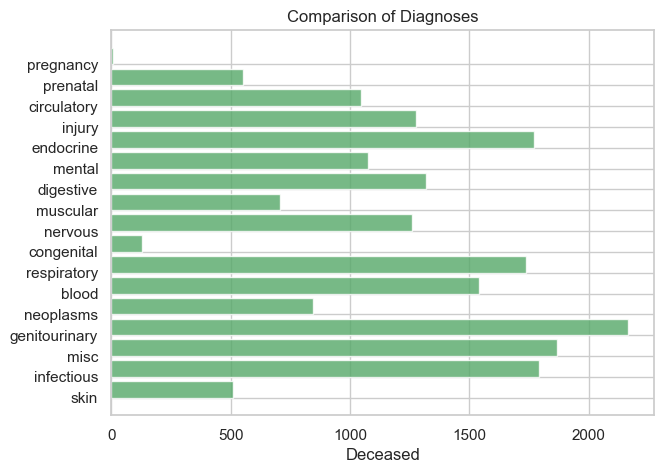

In [42]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory',
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'DECEASED']].groupby(variable).sum().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Deceased')
ax.tick_params(left=False, right=False, top=False)
ax.set_title('Comparison of Diagnoses'.format(variable))

**Feature Engineering: Patients Table**

In [43]:
df_pat = pd.read_csv('PATIENTS.csv')

In [44]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [45]:
df_pat['GENDER'].value_counts()

GENDER
M    26121
F    20399
Name: count, dtype: int64

In [46]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [47]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [48]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

In [49]:
df.head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,0,1,0,0,0,0,2131-05-07,F
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,0,1,0,0,0,0,2082-07-17,M
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,0,1,1,0,1,0,0,2082-07-17,M
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,2100-05-31,M
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,2101-11-21,M


In [50]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [51]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [52]:
# Verify merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,2,163353,2138-07-17 19:04:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,...,0,0,0,0,0,0,0,2138-07-17,M,2138-07-17 19:04:00
1,3,145834,2101-10-20 19:08:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,RELIGIOUS,...,0,0,0,0,0,0,1,2025-04-11,M,2101-10-20 19:08:00
2,4,185777,2191-03-16 00:28:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2143-05-12,F,2191-03-16 00:28:00
3,5,178980,2103-02-02 04:31:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2103-02-02,M,2103-02-02 04:31:00
4,6,107064,2175-05-30 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,...,0,0,0,0,0,0,0,2109-06-21,F,2175-05-30 07:15:00


In [53]:
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
df['DOB'] = pd.to_datetime(df['DOB']).dt.date
df['age'] = df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days/365, axis=1)

#df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN'])
#df['DOB'] = pd.to_datetime(df['DOB'])
#df['age'] = (df['ADMIT_MIN'].sub(df['DOB'], axis=0))// np.timedelta64(1, 'Y')
print(df.head())
#df['age'].isnull().sum()

   SUBJECT_ID  HADM_ID            ADMITTIME DEATHTIME ADMISSION_TYPE  \
0           2   163353  2138-07-17 19:04:00       NaN        NEWBORN   
1           3   145834  2101-10-20 19:08:00       NaN      EMERGENCY   
2           4   185777  2191-03-16 00:28:00       NaN      EMERGENCY   
3           5   178980  2103-02-02 04:31:00       NaN        NEWBORN   
4           6   107064  2175-05-30 07:15:00       NaN       ELECTIVE   

          ADMISSION_LOCATION         DISCHARGE_LOCATION INSURANCE LANGUAGE  \
0  PHYS REFERRAL/NORMAL DELI                       HOME   Private      NaN   
1       EMERGENCY ROOM ADMIT                        SNF  Medicare      NaN   
2       EMERGENCY ROOM ADMIT  HOME WITH HOME IV PROVIDR   Private      NaN   
3  PHYS REFERRAL/NORMAL DELI                       HOME   Private      NaN   
4  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE  Medicare     ENGL   

        RELIGION  ... neoplasms nervous pregnancy  prenatal  respiratory  \
0  NOT SPECIFIED  ... 

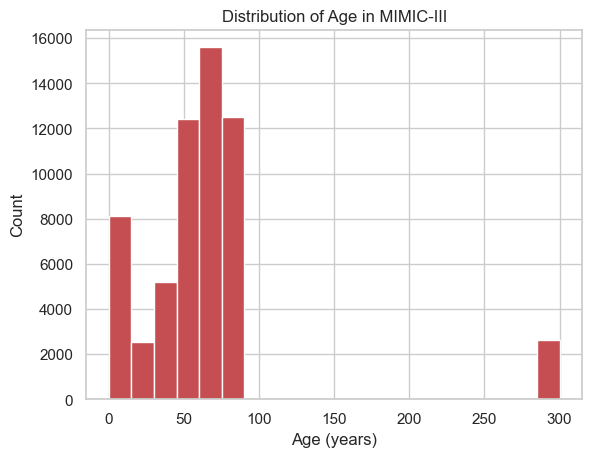

In [54]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show();

In [55]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]),
            num, df['age'])

age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

age
senior          32141
middle_adult    12101
newborn          8110
young_adult      4008
300.2            2616
Name: count, dtype: int64

In [56]:
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

C:\Users\Water\AppData\Local\Temp\ipykernel_37092\1715981341.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
C:\Users\Water\AppData\Local\Temp\ipykernel_37092\1715981341.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['GENDER'].replace({

**Feature Engineering: ICUSTAYS Table**

In [57]:
df_icu = pd.read_csv('ICUSTAYS.csv')

In [58]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [59]:
df_icu['HADM_ID'].nunique()

57786

In [60]:
df_icu['FIRST_CAREUNIT']

0         MICU
1         MICU
2          CCU
3         MICU
4          CCU
         ...  
61527     CSRU
61528      CCU
61529     SICU
61530     CSRU
61531    TSICU
Name: FIRST_CAREUNIT, Length: 61532, dtype: object

In [61]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [62]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [63]:
df_icu['FIRST_CAREUNIT'].value_counts()

FIRST_CAREUNIT
ICU     53432
NICU     8100
Name: count, dtype: int64

In [64]:
icu_list.columns

Index(['HADM_ID', 'cat'], dtype='object')

In [65]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [66]:
icu_item.value_counts()

ICU  NICU  HADM_ID
1    0     199999     1
0    1     100023     1
           100025     1
           100029     1
           100044     1
                     ..
           100162     1
           100159     1
           100135     1
           100125     1
           100121     1
Name: count, Length: 57786, dtype: int64

In [67]:

print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [68]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'DECEASED',
       'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin',
       'DOB', 'GENDER', 'ADMIT_MIN', 'age'],
      dtype='object')

In [69]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [70]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,age,ICU,NICU
0,58526,100001,2117-09-11 11:46:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,RELIGIOUS,...,0,0,0,1,2082-03-21,1,2117-09-11,young_adult,1.0,0.0
1,54610,100003,2150-04-17 15:34:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,NOT SPECIFIED,...,0,0,0,0,2090-05-19,0,2150-04-17,senior,1.0,0.0
2,9895,100006,2108-04-06 15:49:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,NOT SPECIFIED,...,0,0,3,0,2059-05-07,1,2108-04-06,middle_adult,1.0,0.0
3,23018,100007,2145-03-31 05:33:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,RELIGIOUS,...,0,0,1,0,2071-06-04,1,2145-03-31,senior,1.0,0.0
4,533,100009,2162-05-16 15:56:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Private,NaN,RELIGIOUS,...,0,0,0,0,2101-07-30,0,2162-05-16,senior,1.0,0.0


In [71]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

C:\Users\Water\AppData\Local\Temp\ipykernel_37092\1541659716.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ICU'].fillna(value=0, inplace=True)
C:\Users\Water\AppData\Local\Temp\ipykernel_37092\1541659716.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [72]:

# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

ICU
1.0    49794
0.0     9182
Name: count, dtype: int64
NICU
0.0    50984
1.0     7992
Name: count, dtype: int64


**Data Cleaning and Data Splitting**

In [73]:
# Look at what is no longer needed in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          58976 non-null  int64  
 1   HADM_ID             58976 non-null  int64  
 2   ADMITTIME           58976 non-null  object 
 3   DEATHTIME           5854 non-null   object 
 4   ADMISSION_TYPE      58976 non-null  object 
 5   ADMISSION_LOCATION  58976 non-null  object 
 6   DISCHARGE_LOCATION  58976 non-null  object 
 7   INSURANCE           58976 non-null  object 
 8   LANGUAGE            33644 non-null  object 
 9   RELIGION            58976 non-null  object 
 10  MARITAL_STATUS      58976 non-null  object 
 11  ETHNICITY           58976 non-null  object 
 12  DIAGNOSIS           58951 non-null  object 
 13  DECEASED            58976 non-null  int64  
 14  blood               58976 non-null  int64  
 15  circulatory         58976 non-null  int64  
 16  cong

In [74]:
df['DECEASED'].value_counts()

DECEASED
0    53122
1     5854
Name: count, dtype: int64

In [75]:
df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS',   'DEATHTIME'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ADMISSION_TYPE  58976 non-null  object 
 1   INSURANCE       58976 non-null  object 
 2   RELIGION        58976 non-null  object 
 3   MARITAL_STATUS  58976 non-null  object 
 4   ETHNICITY       58976 non-null  object 
 5   DECEASED        58976 non-null  int64  
 6   blood           58976 non-null  int64  
 7   circulatory     58976 non-null  int64  
 8   congenital      58976 non-null  int64  
 9   digestive       58976 non-null  int64  
 10  endocrine       58976 non-null  int64  
 11  genitourinary   58976 non-null  int64  
 12  infectious      58976 non-null  int64  
 13  injury          58976 non-null  int64  
 14  mental          58976 non-null  int64  
 15  misc            58976 non-null  int64  
 16  muscular        58976 non-null  int64  
 17  neoplasms       58976 non-null 

In [76]:
df.head()

,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DECEASED,blood,circulatory,congenital,digestive,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,GENDER,age,ICU,NICU
0,EMERGENCY,Private,RELIGIOUS,DIVORCED,WHITE,0,0,2,0,2,...,0,2,0,0,0,1,1,young_adult,1.0,0.0
1,EMERGENCY,Private,NOT SPECIFIED,SINGLE,WHITE,0,1,2,0,4,...,0,0,0,0,0,0,0,senior,1.0,0.0
2,EMERGENCY,Private,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,0,0,0,0,0,...,1,0,0,0,3,0,1,middle_adult,1.0,0.0
3,EMERGENCY,Private,RELIGIOUS,MARRIED,WHITE,0,0,1,0,2,...,0,0,0,0,1,0,1,senior,1.0,0.0
4,EMERGENCY,Private,RELIGIOUS,MARRIED,WHITE,0,1,7,0,0,...,0,0,0,0,0,0,0,senior,1.0,0.0


In [77]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols,dtype='int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DECEASED                    58976 non-null  int64  
 1   blood                       58976 non-null  int64  
 2   circulatory                 58976 non-null  int64  
 3   congenital                  58976 non-null  int64  
 4   digestive                   58976 non-null  int64  
 5   endocrine                   58976 non-null  int64  
 6   genitourinary               58976 non-null  int64  
 7   infectious                  58976 non-null  int64  
 8   injury                      58976 non-null  int64  
 9   mental                      58976 non-null  int64  
 10  misc                        58976 non-null  int64  
 11  muscular                    58976 non-null  int64  
 12  neoplasms                   58976 non-null  int64  
 13  nervous                     589

In [78]:
# Verify
df.head()

,DECEASED,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,0,0,2,0,2,5,2,0,2,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,2,0,4,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,0,0,2,1,...,0,0,0,0,1,0,0,1,0,0
3,0,0,1,0,2,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,7,0,0,3,0,0,7,0,...,0,0,1,0,0,0,0,0,1,0


In [79]:
df.columns

Index(['DECEASED', 'blood', 'circulatory', 'congenital', 'digestive',
       'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc',
       'muscular', 'neoplasms', 'nervous', 'pregnancy', 'prenatal',
       'respiratory', 'skin', 'GENDER', 'ICU', 'NICU', 'ADM_ELECTIVE',
       'ADM_EMERGENCY', 'ADM_NEWBORN', 'ADM_URGENT', 'INS_Government',
       'INS_Medicaid', 'INS_Medicare', 'INS_Private', 'INS_Self Pay',
       'REL_NOT SPECIFIED', 'REL_RELIGIOUS', 'REL_UNOBTAINABLE', 'ETH_ASIAN',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC/LATINO',
       'ETH_OTHER/UNKNOWN', 'ETH_WHITE', 'AGE_300.2', 'AGE_middle_adult',
       'AGE_newborn', 'AGE_senior', 'AGE_young_adult', 'MAR_DIVORCED',
       'MAR_LIFE PARTNER', 'MAR_MARRIED', 'MAR_SEPARATED', 'MAR_SINGLE',
       'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED', 'RELIGION_NOT SPECIFIED',
       'RELIGION_RELIGIOUS', 'RELIGION_UNOBTAINABLE'],
      dtype='object')

In [80]:
# Target Variable DECEASED
DECEASED = df['DECEASED'].values
# Prediction Features
features = df.drop(columns=['DECEASED'])

In [81]:
features.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,0,2,0,2,5,2,0,2,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,2,0,4,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,1,0,0,2,1,1,...,0,0,0,0,1,0,0,1,0,0
3,0,1,0,2,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,...,0,0,1,0,0,0,0,0,1,0


In [82]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   blood                       58976 non-null  int64  
 1   circulatory                 58976 non-null  int64  
 2   congenital                  58976 non-null  int64  
 3   digestive                   58976 non-null  int64  
 4   endocrine                   58976 non-null  int64  
 5   genitourinary               58976 non-null  int64  
 6   infectious                  58976 non-null  int64  
 7   injury                      58976 non-null  int64  
 8   mental                      58976 non-null  int64  
 9   misc                        58976 non-null  int64  
 10  muscular                    58976 non-null  int64  
 11  neoplasms                   58976 non-null  int64  
 12  nervous                     58976 non-null  int64  
 13  pregnancy                   589

In [83]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    DECEASED,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 47180 samples.
Testing set has 11796 samples.


# Patient Segmentation

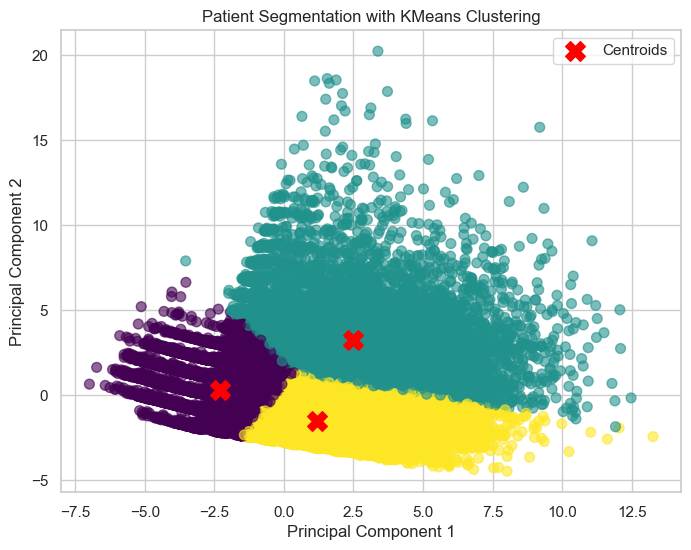

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Apply PCA for dimensionality reduction
PCA_MODEL = PCA(n_components=2)
DATA_PCA = PCA_MODEL.fit_transform(features)

# Perform K-Means clustering
KMEANS_MODEL = KMeans(n_clusters=3, n_init='auto')
KMEANS_MODEL.fit(DATA_PCA)

# Predict cluster labels
CLUSTER_LABELS = KMEANS_MODEL.labels_


# Visualize clusters with centroids
plt.figure(figsize=(8, 6))
plt.scatter(DATA_PCA[:, 0], DATA_PCA[:, 1], c=CLUSTER_LABELS, cmap='viridis', s=50, alpha=0.6)

# Plot the centroids of each cluster
centroids = KMEANS_MODEL.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('Patient Segmentation with KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [85]:
# Analyze cluster characteristics
CLUSTER_DATA = pd.concat([df, pd.DataFrame(CLUSTER_LABELS, columns=['CLUSTER'])], axis=1)

# Print cluster statistics
for cluster in range(3):
    print(f'Cluster {cluster}:')
    print(CLUSTER_DATA[CLUSTER_DATA['CLUSTER'] == cluster].describe())

Cluster 0:
           DECEASED         blood   circulatory    congenital     digestive  \
count  23941.000000  23941.000000  23941.000000  23941.000000  23941.000000   
mean       0.063281      0.239798      0.434986      0.123345      0.478844   
std        0.243472      0.541445      0.632523      0.478387      0.987950   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      1.000000   
max        1.000000      4.000000      3.000000     11.000000     10.000000   

          endocrine  genitourinary    infectious        injury        mental  \
count  23941.000000   23941.000000  23941.000000  23941.000000  23941.000000   
mean       0.520655       0.230358      0.246314      2.139343      0.397937   
std        0.871316       0.565529   

**Machine Learning Models**

In [86]:
from dataclasses import dataclass

@dataclass
class ModelMetric:
    accuracy: float
    f1score: float



In [87]:
# Regression models for comparison
models = [SGDClassifier(random_state = 0),
          GradientBoostingClassifier(random_state = 0),
          LogisticRegression(max_iter=5000),
          RandomForestClassifier(random_state = 0)] #KNeighborsClassifier()

model_metrics = {}
for model in models:
    name = str(model).split("(")[0]
    print(f"Model={name}")
    # Instantiate and fit Regressor Model
    reg_model = model
    
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    

    model_metrics[name] = ModelMetric(accuracy = round(accuracy_score(y_test, y_test_preds),4),
                                      f1score=round(f1_score(y_test, y_test_preds, average='weighted'),4))

    print('{} done.'.format(name))

Model=SGDClassifier
SGDClassifier done.
Model=GradientBoostingClassifier
GradientBoostingClassifier done.
Model=LogisticRegression
LogisticRegression done.
Model=RandomForestClassifier
RandomForestClassifier done.


In [88]:
#sort the data for display by F1Score
sorted_model_metrics = dict(sorted(model_metrics.items(), key=lambda item: item[1].f1score,reverse=True))
sorted_model_metrics

{'GradientBoostingClassifier': ModelMetric(accuracy=0.899, f1score=np.float64(0.8586)),
 'RandomForestClassifier': ModelMetric(accuracy=0.8976, f1score=np.float64(0.8564)),
 'LogisticRegression': ModelMetric(accuracy=0.896, f1score=np.float64(0.8559)),
 'SGDClassifier': ModelMetric(accuracy=0.8975, f1score=np.float64(0.849))}

In [89]:
from prettytable.colortable import ColorTable, Themes

table = ColorTable(theme=Themes.OCEAN)

table.field_names = ['Model', 'Accuracy', 'f1-score (weighted)']
for k, v in sorted_model_metrics.items():
    table.add_row([k,v.accuracy, v.f1score])
print(table)

+----------------------------+----------+---------------------+
|           Model            | Accuracy | f1-score (weighted) |
+----------------------------+----------+---------------------+
| GradientBoostingClassifier |  0.899   |        0.8586       |
|   RandomForestClassifier   |  0.8976  |        0.8564       |
|     LogisticRegression     |  0.896   |        0.8559       |
|       SGDClassifier        |  0.8975  |        0.849        |
+----------------------------+----------+---------------------+


In [90]:
# GradientBoostingRegressor will be used as the DESEASED prediction model
reg_model = GradientBoostingClassifier(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
f1_not_optimized = round(f1_score(y_test, y_test_preds, average='weighted'),4)
print(f"F1 score (Not Optimized) is: {f1_not_optimized}")

F1 score (Not Optimized) is: 0.8586


**Model Finetuning**

In [91]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    DECEASED,
                                                    test_size = .20,
                                                    random_state = 42)


tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['log_loss', 'exponential']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingClassifier()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.9018228062738448
GradientBoostingClassifier(loss='exponential', max_depth=4, n_estimators=200)


In [92]:
#Best Model from optimizer, hardcoded to save time at every execution
# reg_model_optimized = GradientBoostingClassifier(loss='exponential',n_estimators = 200, max_depth=4, random_state=42)
# reg_model_optimized.fit(X_train, y_train)

y_test_preds = reg_model_optimized.predict(X_test)
f1_optimized = round(f1_score(y_test, y_test_preds, average='weighted'),4)
print(f"Optimized F1 score is: {f1_optimized}")

Optimized F1 score is: 0.8664


In [93]:
print('Model refinement improved f1 score by {:.4f}'.format(f1_optimized-f1_not_optimized))

Model refinement improved f1 score by 0.0078


**Evaluation**

In [94]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
respiratory,0.203666
infectious,0.072884
neoplasms,0.072772
genitourinary,0.052706
digestive,0.043920
mental,0.043270
misc,0.042840
ADM_EMERGENCY,0.042807
circulatory,0.042028
nervous,0.040114


In [95]:
feature_imp.index[0:10].tolist()

['respiratory',
 'infectious',
 'neoplasms',
 'genitourinary',
 'digestive',
 'mental',
 'misc',
 'ADM_EMERGENCY',
 'circulatory',
 'nervous']

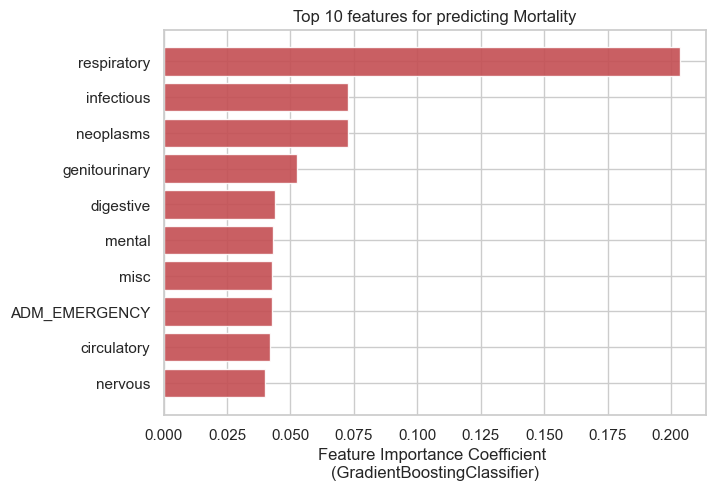

In [96]:

# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10],
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting Mortality")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingClassifier)')
plt.gca().invert_yaxis()
#fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

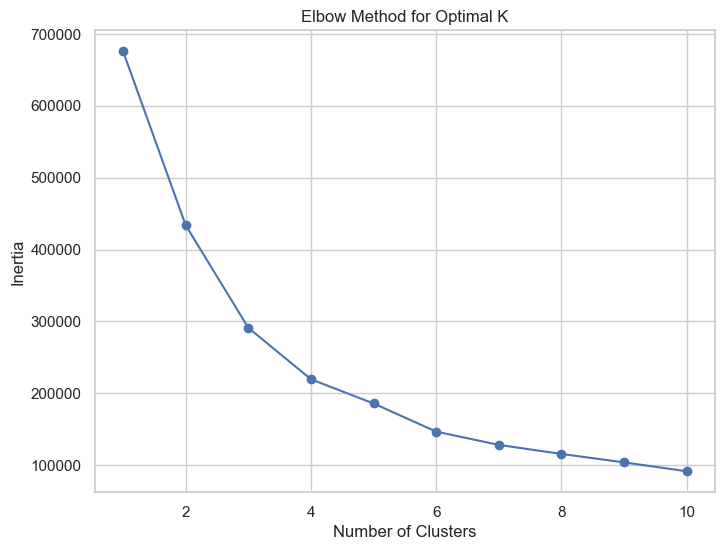

In [97]:
# Elbow plot to determine optimal number of clusters
inertia = []
for k in range(1, 11):  # Test from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(DATA_PCA)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


# Bonus - Neural Networks

In [98]:
%load_ext tensorboard

In [99]:
%tensorboard --logdir runs

In [100]:
#sort the data for display by F1Score
sorted_model_metrics = dict(sorted(model_metrics.items(), key=lambda item: item[1].f1score,reverse=True))
sorted_model_metrics
from prettytable.colortable import ColorTable, Themes

table = ColorTable(theme=Themes.OCEAN)

table.field_names = ['Model', 'Accuracy', 'f1-score (weighted)']
for k, v in sorted_model_metrics.items():
    table.add_row([k,v.accuracy, v.f1score])
print(table)

+----------------------------+----------+---------------------+
|           Model            | Accuracy | f1-score (weighted) |
+----------------------------+----------+---------------------+
| GradientBoostingClassifier |  0.899   |        0.8586       |
|   RandomForestClassifier   |  0.8976  |        0.8564       |
|     LogisticRegression     |  0.896   |        0.8559       |
|       SGDClassifier        |  0.8975  |        0.849        |
+----------------------------+----------+---------------------+


In [101]:
df['DECEASED'].value_counts()

DECEASED
0    53122
1     5854
Name: count, dtype: int64

In [102]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, DECEASED, test_size=0.2, random_state=42)


# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convert the data into PyTorch tensors
X_train_final = torch.from_numpy(X_train_scaled).float()
X_test_final = torch.from_numpy(X_test_scaled).float()
y_train_final = torch.from_numpy(y_train).long()
y_test_final = torch.from_numpy(y_test).long()


# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Dropout(p=0.2),

            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            
            nn.Dropout(p=0.2),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            
            nn.Dropout(p=0.2),
            
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )        

    def forward(self, x):
        return self.classifier(x)


# Initialize the model, loss function, and optimizer
model = BinaryClassifier().to(device="cuda")
criterion = nn.CrossEntropyLoss(weight=torch.tensor([8.0, 1.0])).to(device="cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.001

lr_scheduler = torch.optim.lr_scheduler.StepLR( optimizer, 
                                                step_size = 50, 
                                                gamma = 0.1)

X_train_final = X_train_final.to(device="cuda")
y_train_final = y_train_final.to(device="cuda")

# Train the model
for epoch in range(1300):  # loop over the dataset multiple times
    optimizer.zero_grad()
    outputs = model(X_train_final)
    loss = criterion(outputs, y_train_final)
    loss.backward()
    optimizer.step()
#     lr_scheduler.step()
    if epoch % 20 == 0:
        print('Epoch {}: Loss = {:.5f}'.format(epoch+1, loss.item()))


Epoch 1: Loss = 0.70564
Epoch 21: Loss = 0.07601
Epoch 41: Loss = 0.06796
Epoch 61: Loss = 0.06444
Epoch 81: Loss = 0.06341
Epoch 101: Loss = 0.06222
Epoch 121: Loss = 0.06026
Epoch 141: Loss = 0.05716
Epoch 161: Loss = 0.05245
Epoch 181: Loss = 0.04670
Epoch 201: Loss = 0.04360
Epoch 221: Loss = 0.03825
Epoch 241: Loss = 0.05317
Epoch 261: Loss = 0.04364
Epoch 281: Loss = 0.03209
Epoch 301: Loss = 0.02646
Epoch 321: Loss = 0.02208
Epoch 341: Loss = 0.03436
Epoch 361: Loss = 0.03343
Epoch 381: Loss = 0.01647
Epoch 401: Loss = 0.01318
Epoch 421: Loss = 0.01357
Epoch 441: Loss = 0.00902
Epoch 461: Loss = 0.00849
Epoch 481: Loss = 0.00927
Epoch 501: Loss = 0.01134
Epoch 521: Loss = 0.00678
Epoch 541: Loss = 0.00647
Epoch 561: Loss = 0.00563
Epoch 581: Loss = 0.00482
Epoch 601: Loss = 0.00508
Epoch 621: Loss = 0.00440
Epoch 641: Loss = 0.00415
Epoch 661: Loss = 0.00403
Epoch 681: Loss = 0.00366
Epoch 701: Loss = 0.00396
Epoch 721: Loss = 0.00314
Epoch 741: Loss = 0.00296
Epoch 761: Loss = 

In [103]:
# Evaluate the model
model.eval()
X_test_final = X_test_final.to(device="cuda")
y_test_final = y_test_final.to(device='cuda')

outputs = model(X_test_final)
_, predicted = torch.max(outputs, 1)

print('Accuracy:', accuracy_score(y_test_final.cpu(), predicted.cpu()))
print('Classification Report:')
print(classification_report(y_test_final.cpu(), predicted.cpu()))
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test_final.cpu(), predicted.cpu()))


f1score=f1_score(y_test_final.cpu(), predicted.cpu(), average='weighted')
model_metrics['Neural Network'] = ModelMetric(accuracy=round(accuracy_score(y_test_final.cpu(), predicted.cpu()),4), 
                                              f1score=round(f1score,4))

Accuracy: 0.8789420142421159
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     10629
           1       0.31      0.18      0.23      1167

    accuracy                           0.88     11796
   macro avg       0.61      0.57      0.58     11796
weighted avg       0.85      0.88      0.86     11796

Neural Network Confusion Matrix:
[[10157   472]
 [  956   211]]


In [104]:
#sort the data for display by F1Score
sorted_model_metrics = dict(sorted(model_metrics.items(), key=lambda item: item[1].f1score,reverse=True))
sorted_model_metrics
from prettytable.colortable import ColorTable, Themes

table = ColorTable(theme=Themes.OCEAN)

table.field_names = ['Model', 'Accuracy', 'f1-score (weighted)']
for k, v in sorted_model_metrics.items():
    table.add_row([k,v.accuracy, v.f1score])
print(table)

+----------------------------+----------+---------------------+
|           Model            | Accuracy | f1-score (weighted) |
+----------------------------+----------+---------------------+
|       Neural Network       |  0.8789  |        0.8645       |
| GradientBoostingClassifier |  0.899   |        0.8586       |
|   RandomForestClassifier   |  0.8976  |        0.8564       |
|     LogisticRegression     |  0.896   |        0.8559       |
|       SGDClassifier        |  0.8975  |        0.849        |
+----------------------------+----------+---------------------+
